In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math

In [13]:
cuda_availability = torch.cuda.is_available()

device = torch.device('cuda:0' if cuda_availability else 'cpu')
print('CUDA availability:', ('True' if cuda_availability else 'False'))
print('Device:', device)

class_names = [str(x) for x in range(10)]+list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')+list('abcdefghijklmnopqrstuvwxyz')

CUDA availability: False
Device: cpu


### Hyperparameters

In [3]:
batch_size = 16
num_epochs = 16

#### Transforms

In [4]:
mean=[0.5] * 3
std=[0.5] * 3

def binarize(im):
    im = (im-im.min()) / (im.max()-im.min())
    im = im > 0.55
    im = im.float()
    return im

trans = transforms.Compose([
    transforms.Resize((80,64)),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=mean,
        std=std
    ),
    transforms.Lambda(binarize)
])

### Dataloaders

In [7]:
train_path = 'EnglishImg/train'
test_path = 'test'


# char_datasets = {x: datasets.ImageFolder(os.path.join(path, x), trans) for x in ['train', 'val']}
char_datasets = datasets.ImageFolder(train_path, trans)
test_dataset = datasets.ImageFolder(test_path, trans)

train_size = int(0.8*len(char_datasets))
val_size = len(char_datasets)-train_size
trainset, valset = torch.utils.data.random_split(char_datasets, [train_size, val_size])

char_datasets = {'train':trainset,'val':valset}

dataloaders = {x: torch.utils.data.DataLoader(char_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(char_datasets[x]) for x in ['train', 'val']}
char_datasets['train'].classes = class_names

testloader = torch.utils.data.DataLoader(test_dataset)

print('Dataset sizes:', dataset_sizes)

Dataset sizes: {'train': 6164, 'val': 1541}


### Sample batch

In [11]:
def imshow(im, title=None, save=None):
    im = im.numpy().transpose((1, 2, 0))
    plt.imshow(im)
    if title is not None:
        plt.title(title)
    if save is not None:
        plt.savefig(save)

inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=f'Sample image(s) {"".join(class_names[x] for x in classes)}', save=f'Sample_{batch_size}.png')

KeyboardInterrupt: 

In [10]:
def train(model, criterion, optimizer, scheduler, num_epochs=num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, dataloader, num_images=batch_size):
    was_training = model.training
    model.eval()
    images_so_far = 0
    img_total = 0
    fig = plt.figure(figsize=(8,6))
    
    correct = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            correct += torch.sum(preds == labels)
            img_total += len(preds)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(math.ceil(num_images/8), 8, images_so_far)
                ax.axis('off')
                ax.set_title(class_names[preds[j]])
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    acc = correct.double() / img_total
                    print('Accuracy:', acc.item())
                    return acc.item()

        acc = correct.double() / img_total
        print('Accuracy:', acc.item())
        model.train(mode=was_training)
        return acc.item()

In [12]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 62)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=num_epochs)

### Save model

In [ ]:
# torch.save(model_ft, f'trained_{batch_size}_{num_epochs}.pth')

### Load model

Accuracy: 0.90625


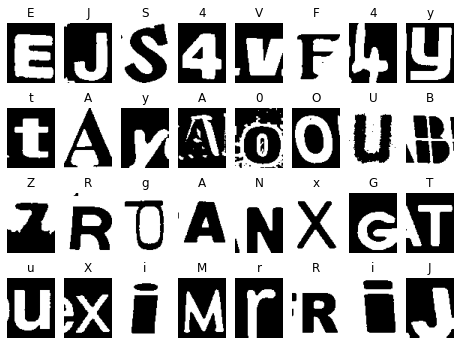

In [16]:
load_batch = 32
load_epochs = 8
model_load = torch.load(f'trained_{load_batch}_{load_epochs}.pth')

acc = visualize_model(model_load, dataloader=dataloaders['val'], num_images=32)
plt.savefig(f'Result_{load_batch}_{load_epochs}_{acc}_{int(round(time.time()) % 24*60)}.png')
plt.show()

In [14]:
load_batch = 32
load_epochs = 8
model_load = torch.load(f'trained_{load_batch}_{load_epochs}.pth')

visualize_model(model_load, dataloader=testloader, num_images=6)

plt.savefig(f'Result_{load_batch}_{load_epochs}.png')
plt.show()

/Users/vivian/miniforge3/envs/cv2/lib/python3.8/site-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torchvision.models.resnet.ResNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/vivian/miniforge3/envs/cv2/lib/python3.8/site-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.